# Coronavirus tweets NLP - Text Classification.ipynb
Data Resources : https://www.kaggle.com/datatattle/covid-19-nlp-text-classification

By : Reynold Martua Sinambela

# Import libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras.layers as L
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')          # graph settings
plt.rcParams['figure.figsize'] = (12,5)    # graph settings

import numpy as np 
import pandas as pd

from nltk.corpus import stopwords

import re
import spacy
import collections

In [2]:
import nltk 
nltk.download("stopwords") 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Dataset

In [ ]:
# mounting from google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# import original data
train_temp = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Corona_NLP_train.csv', encoding='latin1')
test_temp  = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Corona_NLP_test.csv', encoding='latin1')

In [5]:
test_temp.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [6]:
train_temp.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


## Data Preprocessing
The downloaded data has been separated to train and test dataset. Since Dicoding submission in NLP requires validation set has to be 20% from total dataset, so that we join the original train and test set first, and split it again to meet the requirement.

## Concatenate Dataframe

In [7]:
df = pd.concat([test_temp,train_temp])

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44955 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       44955 non-null  int64 
 1   ScreenName     44955 non-null  int64 
 2   Location       35531 non-null  object
 3   TweetAt        44955 non-null  object
 4   OriginalTweet  44955 non-null  object
 5   Sentiment      44955 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.4+ MB


## Remove Unnecessary Columns

In [9]:
df = df.drop(columns=['UserName',	'ScreenName',	'Location',	'TweetAt'])

## Checking Missing Value

In [10]:
df.isna().sum()

OriginalTweet    0
Sentiment        0
dtype: int64

## Change Label
We reduce the label dimension by changing 'Extremely Negative' to 'Negative' and 'Extremely Positive' to 'Positive'.

In [11]:
df.replace(to_replace="Extremely Negative", value="Negative", inplace=True)
df.replace(to_replace="Extremely Positive", value="Positive", inplace=True)

## Feature Encoding

In [12]:
# one hot encoding
category = pd.get_dummies(df.Sentiment)
df_new   = pd.concat([df, category], axis=1)
df_new   = df_new.drop(columns='Sentiment')

In [13]:
df_new.head()

,OriginalTweet,Negative,Neutral,Positive
0,TRENDING: New Yorkers encounter empty supermar...,1,0,0
1,When I couldn't find hand sanitizer at Fred Me...,0,0,1
2,Find out how you can protect yourself and love...,0,0,1
3,#Panic buying hits #NewYork City as anxious sh...,1,0,0
4,#toiletpaper #dunnypaper #coronavirus #coronav...,0,1,0


## Predictor and Class

In [14]:
X = df_new['OriginalTweet'].copy()
#X = df_new['OriginalTweet'].values
y = df_new[['Negative',	'Neutral','Positive']].values

In [15]:
z = df_new['OriginalTweet'].values
z.shape

(44955,)

## Data Cleaning
As we can see in the data preview, there are many word/character(s) that have no meaning and useless to be used in model such as urls, tags, digits, etc. Therefore, we delete all those word/character(s) contained in the dataset.

In [16]:
def data_cleaner(tweet):
    tweet = re.sub(r'http\S+', ' ', tweet)   # remove urls
    tweet = re.sub(r'<.*?>',' ', tweet)      # remove html tags
    tweet = re.sub(r'\d+',' ', tweet)        # remove digits
    tweet = re.sub(r'#\w+',' ', tweet)       # remove hashtags
    tweet = re.sub(r'@\w+',' ', tweet)       # remove mentions
    tweet = " ".join([word for word in tweet.split() if not word in stop_words])   # remove stop words
    return tweet

stop_words = stopwords.words('english')
X = X.apply(data_cleaner)

In [17]:
X.head()

0    TRENDING: New Yorkers encounter empty supermar...
1    When I find hand sanitizer Fred Meyer, I turne...
2                          Find protect loved ones . ?
3    buying hits City anxious shoppers stock food&a...
4    # News # NewsMelb One week everyone buying bab...
Name: OriginalTweet, dtype: object

# Data Exploratory
## Label (Class) Distributions

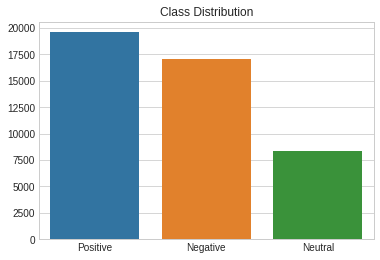

In [18]:
dist_data = df['Sentiment'].value_counts()

def ditribution_plot(x, y, name):
    sns.barplot(x=x, y=y)
    plt.title(name)
    plt.show()

ditribution_plot(x=dist_data.index, y=dist_data.values, name='Class Distribution')

## WordCloud Visualization

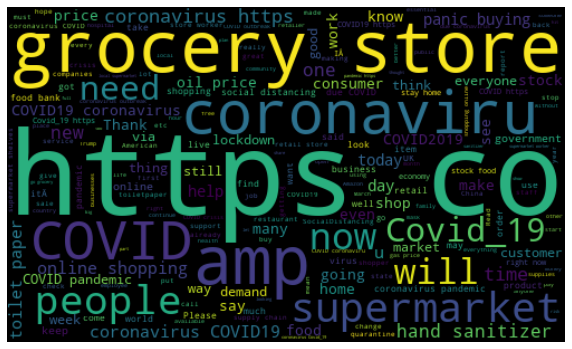

In [19]:
import wordcloud
from wordcloud import WordCloud
allWords = ' '.join([twts for twts in df['OriginalTweet']])
wordCloud = WordCloud(width=500, height=300, random_state=21, max_font_size=110).generate(allWords)

plt.figure(figsize = (10, 8))
plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()

## Tokenizing

In [20]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)
vocab_size = len(tokenizer.word_index) + 1
X = pad_sequences(X, padding='post')

## Splitting Data to Data Train and Test

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

In [ ]:
X_train.shape, y_train.shape

((35964, 64), (35964, 3))

# Modelling
## Model Architecture and Optimizer

In [ ]:
tf.keras.backend.clear_session()

embedding_dim = 54
units = 256

model = tf.keras.Sequential([tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=X.shape[1]),
                             tf.keras.layers.SpatialDropout1D(0.4),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units, return_sequences = True)),
                             tf.keras.layers.GlobalMaxPool1D(),
                             tf.keras.layers.Dropout(0.4),
                             tf.keras.layers.Dense(64,activation="relu"),
                             tf.keras.layers.Dropout(0.4),
                             tf.keras.layers.Dense(3, activation='softmax')])

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 64, 54)            4872042   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 64, 54)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 64, 512)           636928    
_________________________________________________________________
global_max_pooling1d (Global (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                32832     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0

## Callbacks

In [ ]:
#min_acc = 0.91 ; max_loss = 0.5
min_acc = 0.86 ; max_loss = 0.5

class StopCond(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>min_acc and logs.get('loss')<max_loss and logs.get('val_accuracy')>min_acc and logs.get('val_loss')<max_loss):
      print("\Accuracy and Loss condition have been satisfied.")
      self.model.stop_training = True

early_stopping    = StopCond()
adaptive_learning = ReduceLROnPlateau(patience = 2, verbose = 2, factor = 0.5, min_lr = 0.000003)

## Training Model

In [ ]:
import time
start_time = time.time()

In [ ]:
history = model.fit(X_train, y_train, epochs = 100, validation_data = (X_test, y_test), batch_size = 128, callbacks = [early_stopping,adaptive_learning])

Epoch 1/100
 89/281 [========>.....................] - ETA: 14s - loss: 1.0246 - accuracy: 0.4300

KeyboardInterrupt: ignored

From previous experiments, by setting minimum accuracy of train and validation data in > 90%, we find that after reaching 87% (in epoch), the model start to overfit (from 4th epoch and so forth). I am in progress to look for the best ANN architecture to meet 90% of accuracy for all of available data. 

However, to meet the requirements of submission so that I can continue this module, I set the minimum accuracy in 87% even though it is not qualified to get 5 star.

In [ ]:
end_time = time.time()
durasi = (end_time - start_time)/60

print("Time Elapsed for trainig model : ",durasi,"minutes.")

Time Elapsed for trainig model :  0.6492589553197224 minutes.


## History of Model Accuracy and Loss

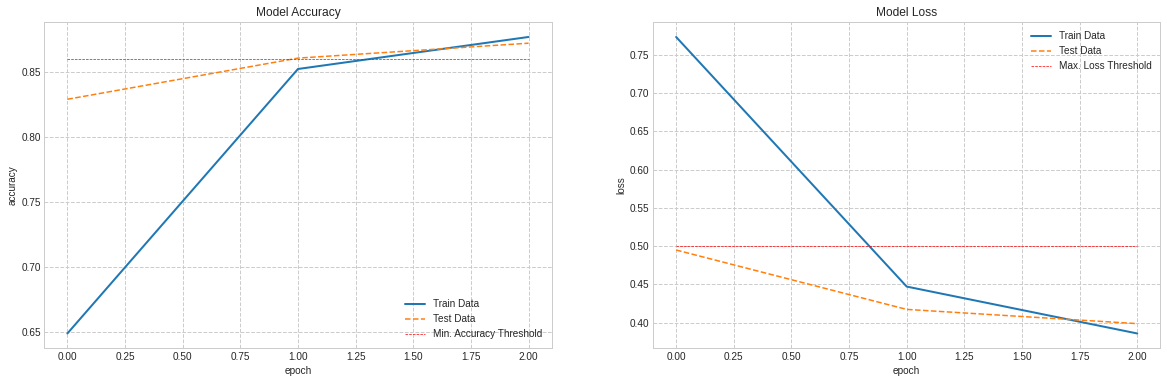

In [ ]:
def plot_trained_model_history(trained_model,min_acc,max_loss):
    acc     = trained_model.history['accuracy']
    val_acc = trained_model.history['val_accuracy']

    loss     = trained_model.history['loss']
    val_loss = trained_model.history['val_loss']

    plt.figure(figsize=(20, 6))

    length   = len(acc)
    min_acc  = [min_acc]*length
    max_loss = [max_loss]*length

    # Grafik Nilai Akurasi
    plt.subplot(1, 2, 1)
    plt.title('Model Accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.plot(acc, label='Train Data',linewidth=2)
    plt.plot(val_acc, label='Test Data', linestyle='--')
    plt.plot(min_acc, label='Min. Accuracy Threshold',linestyle='--',color='red',linewidth=.7)
    plt.legend()
    plt.grid(linestyle='--', linewidth=1)

    # Grafik Nilai Loss
    plt.subplot(1, 2, 2)
    plt.title('Model Loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.plot(loss, label='Train Data',linewidth=2)
    plt.plot(val_loss, label='Test Data', linestyle='--')
    plt.plot(max_loss, label='Max. Loss Threshold',linestyle='--',color='red',linewidth=.7)
    plt.legend()
    plt.grid(linestyle='--', linewidth=1)

    plt.show()

plot_trained_model_history(history,min_acc,max_loss)

# Model Evaluation

In [ ]:
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print('Test loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))

Test loss: 0.39875200390815735
Test Accuracy: 0.8717606663703918


# Prepare for Deployment

In [ ]:
!pip install tensorflowjs

In [ ]:
# word2index = tokenizer.word_index

# import json

# with open('word2index.json', 'w') as fp:
#     json.dump(word2index, fp)

In [ ]:
# saved_model_path = '/content/mymodel/'
# tf.saved_model.save(model, saved_model_path)

In [ ]:
# !tensorflowjs_converter \
#   --input_format=tf_saved_model \
#   /content/mymodel/ \
#   /content/modeltfjs